# FDS Project - Predicting Flight Delays using Flight and Weather Data

## Preliminaries 

In [384]:
import pandas as pd
import numpy as np
import requests 
import html5lib
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re 
import random
from datetime import datetime, timedelta
import csv
import urllib.request
from matplotlib.colors import DivergingNorm
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.impute import KNNImputer

## Constructing the Dataset  



### Note: the code in this section uses local file paths in order to construct the dataset. Please do not run locally if you wish to avoid using local disk space on your machine and/or a lengthy run time. The code for cleaning the dataset is located in [Cleaning the Dataset](#section_id), and the analysis is found in the accompanying R-script. 

First I acquire data on flight delays for January, March, September, and December in 2016, 2017 and 2018 from the [US Bureau of Transportation Statistics](https://www.transtats.bts.gov/Tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r%FDb0-gvzr%FDcr4s14zn0pr%FDQn6n&QO_fu146_anzr=b0-gvzr).

In [146]:
#set seed 
np.random.seed(666)

In [147]:
years = [2016, 2017, 2018]
months = [1, 3, 9,  12]

for year in years:
    for month in months:
        zipref = ZipFile("C:\\Users\\Ollie\\Downloads\\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_" + f"{year}_"+f"{month}.zip","r") 
        zipref.extractall("C:\\Users\\Ollie\\Desktop\\BSE\\Courses\\Foundations of Data Science\\Project\\Data")
        print(f'{year}{month} Completed')

20161 Completed
20163 Completed
20169 Completed
201612 Completed
20171 Completed
20173 Completed
20179 Completed
201712 Completed
20181 Completed
20183 Completed
20189 Completed
201812 Completed


In [148]:
years = [2016, 2017, 2018]
months = [1, 3, 9,  12]

full_dfs=[]

for year in years:
    for month in months:
        df = pd.read_csv("C:\\Users\\Ollie\\Desktop\\BSE\\Courses\\Foundations of Data Science\\Project\\Data\\On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_" + f"{year}_"+f"{month}"+".csv", dtype=object) 
        full_dfs.append(df)
        print(f'{year}{month} Completed')

20161 Completed
20163 Completed
20169 Completed
201612 Completed
20171 Completed
20173 Completed
20179 Completed
201712 Completed
20181 Completed
20183 Completed
20189 Completed
201812 Completed


In [150]:
#random subset of data.
rs_dfs = []

for dfr in full_dfs:
    rs_df = dfr.sample(frac=0.0015)
    rs_dfs.append(rs_df)
    

In [151]:
df  = pd.concat(rs_dfs)

In [152]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
347452,2016,1,1,7,4,2016-01-07,DL,19790,DL,N980AT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8617,2016,1,1,29,5,2016-01-29,AA,19805,AA,N868AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372025,2016,1,1,17,7,2016-01-17,AA,19805,AA,N914UY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227051,2016,1,1,23,6,2016-01-23,HA,19690,HA,N374HA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
321769,2016,1,1,8,5,2016-01-08,UA,19977,UA,N467UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
#keep relevant variables.
keep = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', \
        'IATA_CODE_Reporting_Airline', 'Origin', 'OriginCityName', 'OriginStateName', \
       'OriginWac', 'Dest', 'DestCityName', 'DestStateName', 'DestWac', 'CRSDepTime', \
       'DepDelay', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 'CRSArrTime', 'ArrDelay', \
       'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk', 'Flights', \
        'Distance', 'DistanceGroup']

In [154]:
df_flght = df[keep]

In [155]:
df_flght.to_csv('C:\\Users\\Ollie\\Desktop\\BSE\\Courses\\Foundations of Data Science\\Project\\Code\\FDS-project\\Flight_Data.csv', index=False)

In [156]:
df_flght= pd.read_csv('C:\\Users\\Ollie\\Desktop\\BSE\\Courses\\Foundations of Data Science\\Project\\Code\\FDS-project\\Flight_Data.csv')

In [157]:
df_flght.shape


(8777, 28)

### Download weather data from weather underground corresponding to the IATA airport code and flight date. 

In [181]:
pd.to_datetime(df_flght['FlightDate'], format = '%Y-%m-%d')

347452   2016-01-07
8617     2016-01-29
372025   2016-01-17
227051   2016-01-23
321769   2016-01-08
            ...    
136274   2018-12-27
75569    2018-12-21
193183   2018-12-16
187794   2018-12-21
145089   2018-12-09
Name: FlightDate, Length: 8777, dtype: datetime64[ns]

In [4]:
### Scrape historical weather data from Weather Underground. 

def scrape_station(station, date):
    # Use .format(station, YYYY, M, D)
    URL = 'http://www.wunderground.com/history/daily/{}/date/{}-{}-{}.html'
    
    #Format date components.
    date_year = int(date[0:4])
    date_month = int(date[5:7])
    date_day = int(date[8:10])
    
    #format URl
    formatted_URL = URL.format(station, date_year, date_month, date_day)
    
    #Scrape weather data for specified station on specified date. 
    driver = webdriver.Chrome()
    driver.get(formatted_URL)
    driver.minimize_window()
    tables = WebDriverWait(driver,5).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "table")))
    #Table 0 contains the data that we want. Hourly data is available in the second table.
    newTable = pd.read_html(tables[0].get_attribute('outerHTML'))
    return(newTable[0])

In [8]:
airports = set(list(df_flght['Origin']))
gr_flght=df_flght.groupby(by='Origin')

for airport in airports:
    df_airport_dates = []
    dates = set(list(gr_flght.get_group(airport)['FlightDate']))
    airport_code = 'K' + airport
    for date in dates:
        try:
            df_airport_date = scrape_station(airport_code, date)
            df_airport_date['FlightDate'] = np.tile(date, len(df_airport_date))
            if df_airport_date.shape[1] == 6:
                df_airport_date.columns = ["Stats", "1", "2", "3", "4", "FlightDate"]
            elif df_airport_date.shape[1] == 11:
                df_airport_date.columns = ["Stats", "1", "2", "3", "4", "5", "6", "7", "8", "9", "FlightDate"]
            df_airport_date.reset_index(drop=True)
            df_airport_date = df_airport_date.pivot(index=["FlightDate"], columns=["Stats"], values =["1"])
            df_airport_date['Origin'] = np.tile(airport, len(df_airport_date))
            print(f'{airport}-{date}: done')
            df_airport_dates.append(df_airport_date)
        except Exception as e:
            print(f'{airport}-{date} error: {e}')
            continue
    try:
        df_airport_dates = pd.concat(df_airport_dates)
    except Exception as e:
        print(f'error:{e}')
        continue
    df_airport_dates.to_csv(f'{airport}_data.csv', index=True)
    print(f'{airport}: complete')

MCI-2017-12-29: done
MCI-2018-09-07: done
MCI-2017-01-23: done
MCI-2016-03-30: done
MCI-2018-01-23: done
MCI-2016-12-26: done
MCI-2018-01-16: done
MCI-2018-12-21: done
MCI-2016-01-25: done
MCI-2018-09-03: done
MCI-2018-09-16: done
MCI-2018-09-04: done
MCI-2018-09-10: done
MCI-2018-09-17: done
MCI-2016-09-20: done
MCI-2017-03-23: done
MCI-2018-03-24: done
MCI-2018-01-24: done
MCI-2018-12-08 error: Message: 

MCI-2017-03-10: done
MCI-2018-12-20: done
MCI-2017-03-06: done
MCI-2018-01-29: done
MCI-2016-03-13: done
MCI-2017-03-08: done
MCI-2018-01-30: done
MCI-2016-09-30: done
MCI-2017-12-21: done
MCI-2017-01-18: done
MCI-2018-01-18: done
MCI-2016-09-07: done
MCI-2016-03-27: done
MCI-2017-09-24: done
MCI-2018-12-01 error: Index contains duplicate entries, cannot reshape
MCI-2016-09-28: done
MCI-2018-09-11: done
MCI-2017-12-08: done
MCI-2017-12-19: done
MCI-2016-03-15: done
MCI-2016-12-13: done
MCI-2018-09-23: done
MCI-2016-03-16: done
MCI-2018-03-18: done
MCI-2018-03-04: done
MCI-2017-09-20

TPA-2018-03-20: done
TPA-2017-12-18: done
TPA-2018-12-27: done
TPA-2016-03-17: done
TPA-2017-01-09: done
TPA-2018-12-06: done
TPA-2018-03-25: done
TPA-2016-12-26: done
TPA-2017-01-31: done
TPA-2017-01-19: done
TPA-2018-03-29: done
TPA-2017-03-20: done
TPA-2018-12-10: done
TPA-2016-12-06 error: Index contains duplicate entries, cannot reshape
TPA-2016-03-13: done
TPA-2017-03-25: done
TPA-2018-09-09: done
TPA-2016-12-02: done
TPA-2017-12-17: done
TPA-2016-09-22: done
TPA-2016-03-18: done
TPA-2018-03-03: done
TPA-2017-09-26: done
TPA-2017-12-06: done
TPA-2018-12-24: done
TPA-2016-09-09: done
TPA-2018-09-29: done
TPA-2018-09-28: done
TPA-2018-09-10: done
TPA-2018-01-14: done
TPA-2016-03-29: done
TPA-2016-01-06: done
TPA-2017-12-28: done
TPA-2017-09-09: done
TPA-2017-12-16: done
TPA-2016-09-07: done
TPA-2018-03-21: done
TPA-2016-01-26: done
TPA-2016-12-20: done
TPA-2018-09-08: done
TPA-2018-09-01: done
TPA-2016-01-31: done
TPA-2016-03-11: done
TPA-2017-03-07: done
TPA-2018-01-15: done
TPA-2

ORD-2017-03-16: done
ORD-2016-01-18: done
ORD-2018-03-19: done
ORD-2016-12-28: done
ORD-2017-03-11: done
ORD-2016-03-19: done
ORD-2017-01-10: done
ORD-2016-12-12: done
ORD-2017-09-07: done
ORD-2016-03-03: done
ORD-2016-03-21: done
ORD-2016-09-21: done
ORD-2016-03-07: done
ORD-2017-01-11: done
ORD-2017-03-14: done
ORD-2017-12-09: done
ORD-2018-12-15: done
ORD: complete
BIS-2018-01-29: done
BIS-2016-01-21: done
BIS-2018-09-13: done
BIS-2017-09-19: done
BIS: complete
AVL-2018-09-14: done
AVL-2017-12-02: done
AVL-2017-09-19: done
AVL-2017-09-06: done
AVL: complete
IDA-2018-01-05: done
IDA-2016-01-24: done
IDA-2017-03-08: done
IDA-2017-12-23: done
IDA: complete
GSP-2016-12-01: done
GSP-2018-03-27: done
GSP-2016-12-17: done
GSP-2018-03-17: done
GSP-2017-03-02: done
GSP-2018-03-15: done
GSP-2016-03-31: done
GSP-2018-09-26: done
GSP: complete
PIA-2016-09-26: done
PIA-2016-03-28: done
PIA-2017-03-04: done
PIA-2018-12-17: done
PIA: complete
MFE-2017-09-02: done
MFE-2018-01-12: done
MFE-2016-01-1

In [160]:
#Keep relevant data. 
keep = ['FlightDate', 'Day Average Temp', 'High Temp', 'Low Temp', 'Max Wind Speed', 'Precipitation', 'Sea Level Pressure', \
        'Origin']

#Get relevant airport codes from local directory.
directory_list = os.listdir()
airports = []
for i in directory_list:
    if i[-9:] == '_data.csv': 
       airports.append(i[:-9])

store_data = []

#Import csv file into a pandas dataframe, rename and keep variables of interest, and append to list.
for airport in airports: 
    airport_df = pd.read_csv(f'C:\\Users\\Ollie\\Desktop\\BSE\\Courses\\Foundations of Data Science\\Project\\Code\\FDS-project\\{airport}_data.csv', 
                     header = 1)
    airport_df.rename(columns = {'Stats': 'FlightDate', airport_df.columns[airport_df.columns.str.contains('Unnamed')][0]: 'Origin', \
               airport_df.columns[airport_df.columns.str.contains('Precipitation')][-1]: 'Precipitation'}, inplace = True)
    final_airport_df = airport_df[keep]
    final_airport_df = final_airport_df.iloc[1:]
    store_data.append(final_airport_df)


In [161]:
#Concatenate dataframes and reset index.
airports_weather = pd.concat(store_data, sort=False)
airports_weather.reset_index(drop=True, inplace=True )


In [162]:
#Merge the two dataframes on date and origin.
final_df = pd.merge(df_flght, airports_weather, how='left', on=['FlightDate', 'Origin'])

In [164]:
#save as .csv file
final_df.to_csv('C:\\Users\\Ollie\\Desktop\\BSE\\Courses\\Foundations of Data Science\\Project\\Code\\FDS-project\\Merged_Data.csv', index=False)

## Cleaning the Dataset
<a id='section_id'></a>

In [610]:
#download csv file from GitHub
url = 'https://github.com/Oryder-green/FDS-project/blob/main/Merged_Data.csv?raw=true'
df = pd.read_csv(url, index_col=0)
df = df.reset_index(drop=False)

In [611]:
df.shape
df.head()

,Year,Month,DayofMonth,DayOfWeek,FlightDate,IATA_CODE_Reporting_Airline,Origin,OriginCityName,OriginStateName,OriginWac,...,ArrTimeBlk,Flights,Distance,DistanceGroup,Day Average Temp,High Temp,Low Temp,Max Wind Speed,Precipitation,Sea Level Pressure
0,2016,1,7,4,2016-01-07,DL,BOS,"Boston, MA",Massachusetts,13,...,1200-1259,1.0,184.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,1,29,5,2016-01-29,AA,SAT,"San Antonio, TX",Texas,74,...,1500-1559,1.0,247.0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,1,17,7,2016-01-17,AA,LAX,"Los Angeles, CA",California,91,...,0600-0659,1.0,2402.0,10,57.14,63.0,52.0,17.0,NaN,30.08
3,2016,1,23,6,2016-01-23,HA,PDX,"Portland, OR",Oregon,92,...,1400-1459,1.0,2603.0,11,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,1,8,5,2016-01-08,UA,FLL,"Fort Lauderdale, FL",Florida,33,...,2300-2359,1.0,1065.0,5,NaN,NaN,NaN,NaN,NaN,NaN


**Note**

In the dataset, delays are considered to be a flight departing more than 15 minutes late:
* delayed departures are identified by `DepDel15=1` if delayed and `DepDel15=0` otherwise.

Delays are measured in minutes: 
* departure delays in minutes are given by `DepDelay`. 

Delays are negative if a flight departs early. The interest is in predicting delays only, therefore I hard code early flights to 0:

* `DepDelay > 0` if a flight departs late and `DepDelay = 0` otherwise. 

Because the supervised learning methods I utilise rely on the assumption that the **target variables** do not have missing values, I drop observations if `DepDel15` and `DepDelay` are both missing. To mitigate measurement error, I also drop observations for which `DepDel15=1` and `DepDelay<15` or `DepDel15=0` and `DepDelay≥15`. 


In [612]:
#drop observations missing target variables

#Departure delays
mask1 = df[df['DepDel15'].isna() & df['DepDelay'].isna()].index
df = df.drop(df.index[mask1])

#reset index 
df = df.reset_index(drop=True)

In [613]:
#drop observations with contradictory target values

#Departure delays
mask2 = df[(df['DepDel15'] == 1) & (df['DepDelay'] < 15)].index
mask3 = df[(df['DepDel15'] == 0) & (df['DepDelay'] >= 15)].index

df = df.drop(df.index[mask2])
df = df.drop(df.index[mask3])

#reset index 
df = df.reset_index(drop=True)

In [614]:
#hard code DepDelay = 0 if DepDelay < 0. 
df.loc[df['DepDelay']<0, 'DepDelay'] = 0

**Note**

I am interested in predicting delays and delay lengths using flight characteristics and weather data. I therefore consider the proportion of missing values for these predictor variables.


<ipython-input-615-c5778a9c169b>:25: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm1 = DivergingNorm(vmin=na_df['NA %'].min(), vcenter=na_df['NA %'].mean(), vmax=na_df['NA %'].max())
<ipython-input-615-c5778a9c169b>:28: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm2 = DivergingNorm(vmin=na_df['% Observations Preserved'].min(), vcenter=na_df['% Observations Preserved'].mean(), vmax=na_df['NA %'].max())


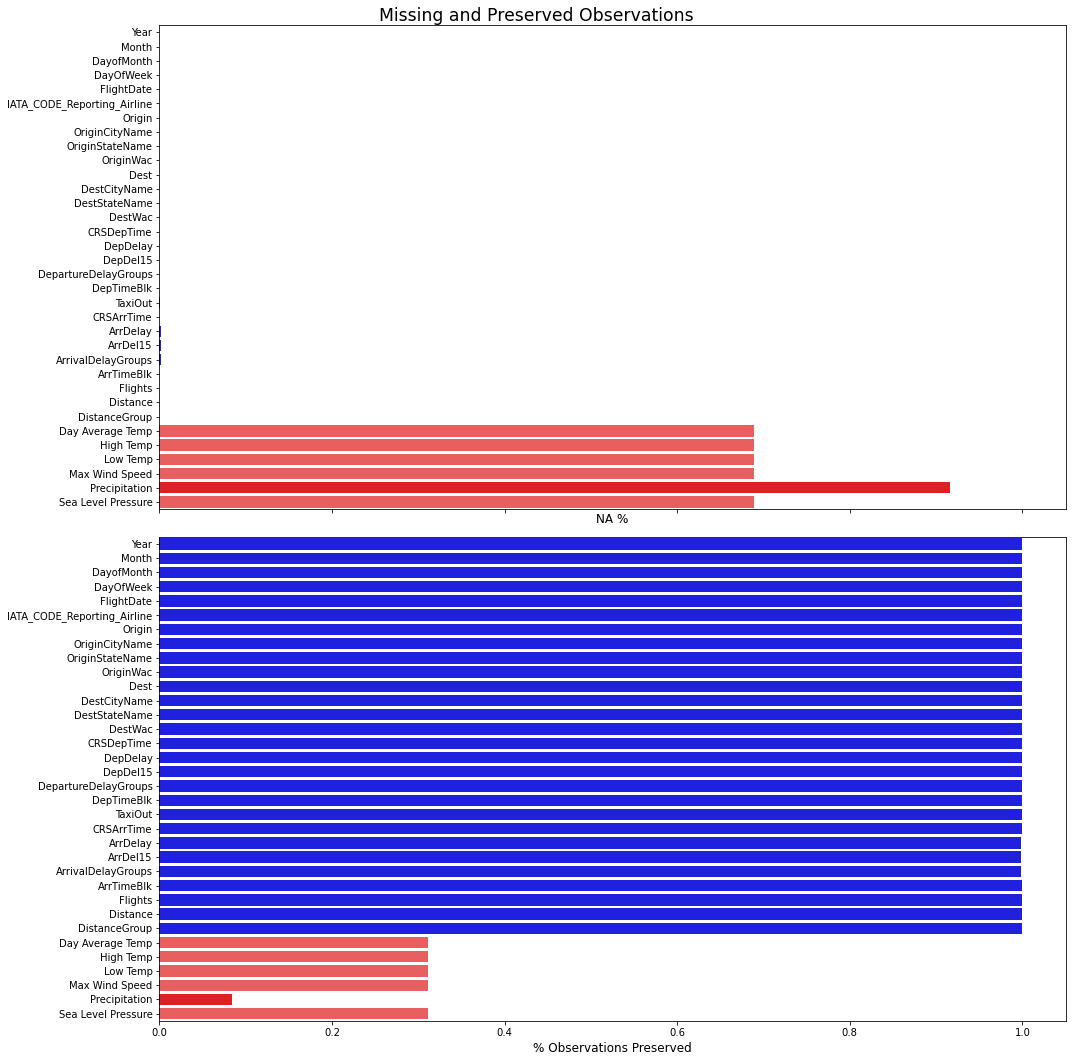

In [615]:
colnames = df.columns
colnames

na_cols = {}
for column in colnames:
    na_mean = df[column].isna().mean()
    na_cols.update({column:na_mean})

#create dataframe from dictionary
na_df = pd.DataFrame.from_dict(na_cols, orient='Index', columns=['NA %'])

#what is the effect of dropping missing values in relevant columns?
for column in colnames: 
    mask = df[df[column].isna()].index
    drop_length = df.drop(df.index[mask]).shape[0]
    na_df.loc[column,['% Observations Preserved']] = drop_length/df.shape[0]


#plot missing values and cost of dropping observations

fig, axes = plt.subplots(2,1, figsize=(15,15), sharex=True)

fig.suptitle('Missing and Preserved Observations',  size= 'xx-large')

norm1 = DivergingNorm(vmin=na_df['NA %'].min(), vcenter=na_df['NA %'].mean(), vmax=na_df['NA %'].max())
colors1 = [plt.cm.bwr(norm1(c)) for c in na_df['NA %']]

norm2 = DivergingNorm(vmin=na_df['% Observations Preserved'].min(), vcenter=na_df['% Observations Preserved'].mean(), vmax=na_df['NA %'].max())
colors2 = [plt.cm.bwr_r(norm2(c)) for c in na_df['% Observations Preserved']]

sns.barplot(y= na_df.index, x=na_df['NA %'], palette=colors1, ax = axes[0]).set_xlabel('NA %', size='large')
sns.barplot(y=na_df.index, x=na_df['% Observations Preserved'], palette=colors2, ax = axes[1]).set_xlabel('% Observations Preserved', size='large')

plt.tight_layout()
plt.show()

**Note**

The weather data contains the highest proportion of missing values and is therefore costly to drop, yet this data is of interest in prediction and is likely independent of many flight characteristics used in prediction. Clearly, `Precipitation` is the most problematic variable in this sense since it contains the highest proportion of NA values and is the most costly to drop.


I choose to omit data for observations that have missing values for `Day Average Temp`, `High Temp`, `Low Temp`, `Max Wind Speed`, and `Sea Level Pressure`. 


Given that:
* omitting further observations that have missing values for `Precipitation` is very costly in terms of observations
* the correlation between `DepDel15` and `Precipitation` and the correlation between `DepDelay` and `Precipitation` are both non-negligible (see below)
* average precipitation is higher for delayed departures and non-delayed departures (see below), 

I am wary of omitting observations that have missing values for `Precipitation` because I may be excluding useful information in the dataset. 


Since `Precipitation` is correlated with other weather observations (see below), I choose to impute missing values of `Precipitation` using observations on `Day Average Temp`, `High Temp`, `Low Temp`, `Max Wind Speed`, and `Sea Level Pressure` using k-Nearest Neighbours (see below).

In [616]:
#drop observations missing Day Average Temp, High Temp, Low Temp, Max Wind Speed and Sea Level Pressure. 
mask4 = df[df['Day Average Temp'].isna() & df['High Temp'].isna() & df['Low Temp'].isna() \
           & df['Max Wind Speed'].isna() & df['Sea Level Pressure'].isna()].index

df = df.drop(df.index[mask4])

#reset index 
df = df.reset_index(drop=True)

In [617]:
#check correlation between departure delays and precipitation. 
corr1 = df['DepDel15'].corr(df['Precipitation'])

#check correlation between departure delay length and precipitation. 
corr2 = df['DepDelay'].corr(df['Precipitation'])

print(f'Delays and Precipitation: {corr1}')
print(f'Delay length and Precipitation: {corr2}')

Delays and Precipitation: 0.08845156497481997
Delay length and Precipitation: 0.04477604722315127


In [618]:
#check conditional mean precipitation for delayed vs non-delayed departures. 
mask5 = df[df['DepDel15'] == 1].index
mask6 = df[df['DepDel15'] == 0].index

avg_prec_delay = df.loc[df['DepDel15']==1, 'Precipitation'].mean()
avg_prec_nodelay = df.loc[df['DepDel15']==0, 'Precipitation'].mean()

print(f'Mean Precipitation delayed departures: {avg_prec_delay}')
print(f'Mean Precipitation non-delayed departures: {avg_prec_nodelay}')

Mean Precipitation delayed departures: 0.441346153846154
Mean Precipitation non-delayed departures: 0.32354385964912274


In [619]:
variables = ['Day Average Temp', 'High Temp', 'Low Temp', 'Max Wind Speed', 'Sea Level Pressure']

weather_corr = {}
for variable in variables:
    corr = df[variable].corr(df['Precipitation'])
    weather_corr.update({variable:corr})
    print(f'Correlation between {variable} and Precipitation: {corr}')  

Correlation between Day Average Temp and Precipitation: 0.10309682727678561
Correlation between High Temp and Precipitation: 0.08358225953991402
Correlation between Low Temp and Precipitation: 0.11438137734767072
Correlation between Max Wind Speed and Precipitation: 0.07043945858408672
Correlation between Sea Level Pressure and Precipitation: 0.013261699350025696


In [548]:
#Imputing precipitation using Day Average Temp, High Temp, Low Temp, Max Wind Speed and Sea Level Pressure.

temp_df = df.loc[:,['Day Average Temp', 'High Temp', 'Low Temp', 'Max Wind Speed', \
                  'Sea Level Pressure', 'Precipitation']]

#First optimise fit of kNN model using MSE. 

#Split sample into train and testing: 
mask7 = temp_df[temp_df['Precipitation'].isna()].index
X = temp_df.drop(temp_df.index[mask7])

errors={}
for rand in range(1, 50, 1):
    train = X.sample(frac=0.6, random_state = rand)
    test = X.drop(x_train.index)
    test = test.reset_index(drop=True)

    #set NAs in test to make prediction.
    impute = test.copy()
    impute['Precipitation'] = np.nan

    #optimise the number of neighbours k. 
    for k in range(1, 100, 1):
        imputer = KNNImputer(n_neighbors=k)
        fitted_imputer = imputer.fit(train)
        #transform NAs.
        imputed = fitted_imputer.transform(impute)
        pred_imputed = pd.DataFrame(imputed, columns=test.columns)
        #Calculate MSE. 
        pred_imputed = pred_imputed.reset_index(drop=True)
        error = test['Precipitation'] - pred_imputed['Precipitation']
        sq_error = error**2
        mean_sq_error = sq_error.mean()
        if k in errors:
            errors[k].append(mean_sq_error)
        else:
            errors[k] = [mean_sq_error]

In [549]:
average_errors = {}
for k in errors: 
    averr = np.mean(errors[k])
    average_errors.update({k: averr})

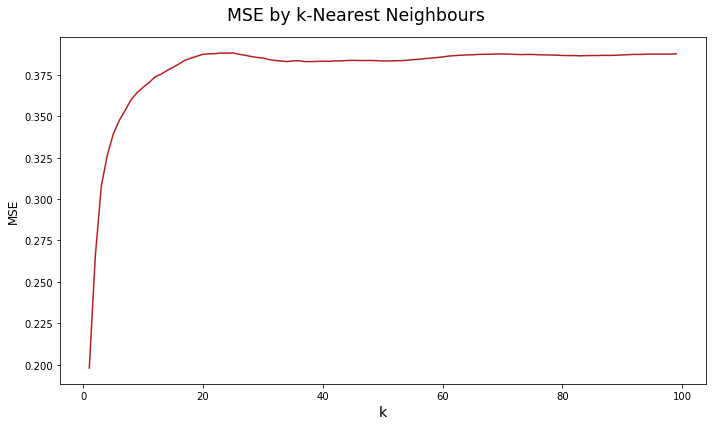

In [550]:
#Plot MSE by k. 
ks = list(average_errors.keys())
av_mses = list(average_errors.values())

fig, axes = plt.subplots(1,1, figsize=(10,6))

fig.suptitle('MSE by k-Nearest Neighbours',  size= 'xx-large')

sns.lineplot(y=av_mses, x=ks, color='firebrick').set_xlabel('k', size='x-large')
plt.ylabel('MSE', size='large')

plt.tight_layout()
plt.show()

In [551]:
#I therefore use just k=1 neighbour in imputing the missing values.
imputer = KNNImputer(n_neighbors=1)

imputed = imputer.fit_transform(temp_df)
imputed_temp_df = pd.DataFrame(imputed, columns=temp_df.columns)


In [624]:
df.loc[df['Precipitation'].isna() == True, 'Imputed Precipitation'] = 1
df.loc[df['Precipitation'].isna() == False, 'Imputed Precipitation'] = 0

df['Precipitation'] = imputed_temp_df['Precipitation']

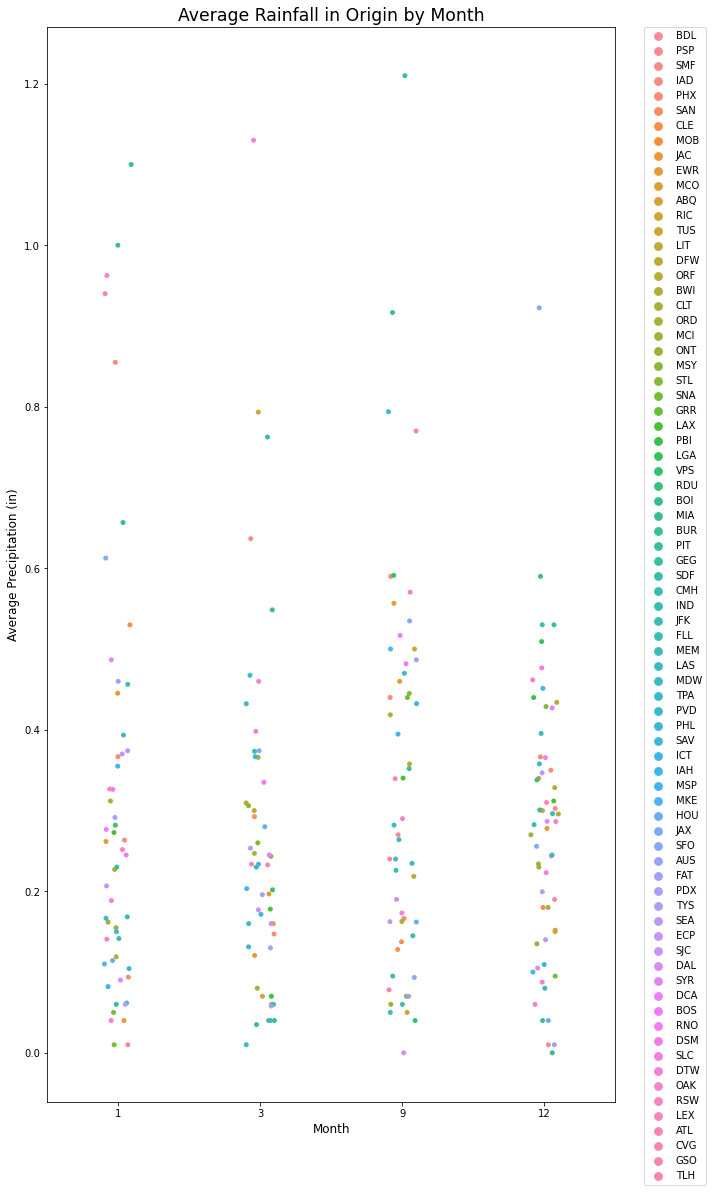

In [564]:
##Change this to delays by Origin and Month. 
origins= set(list(df['Origin']))
months = set(list(df['Month']))

avg_prec_df = pd.DataFrame(columns=np.arange(3))
avg_prec_df.columns = ['Origin','Month','Average Precipitation']

i=0
for origin in origins:
    for month in months:
        avg_prec_df.loc[i, 'Origin'] = origin
        avg_prec_df.loc[i, 'Month'] = month
        prec_mean = df.loc[(df['Month']==month) & (df['Origin']==origin), 'Precipitation'].mean() 
        avg_prec_df.loc[i, 'Average Precipitation'] = prec_mean
        i = i + 1

# plot.

fig, axes = plt.subplots(1,1, figsize=(10,18))

ax = sns.stripplot(x='Month', y='Average Precipitation', hue='Origin', data=avg_prec_df, jitter=True).set_xlabel('Month', size='large')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Average Precipitation (in)', size='large')
plt.title('Average Precipitation in Origin by Month',  size= 'xx-large')

plt.tight_layout()
plt.show()

In [590]:
#Average precipitation appears to be fairly consistent across locations between months. 

#Check locations with highest average rainfall. 

#check top 5 highest average rainfall locations by month.
top5_df = avg_prec_df.sort_values(by=['Average Precipitation'], ascending=False).groupby('Month').head(5)

top5_df = top5_df.sort_values(by=['Month'])

top5_df

#none of these airports seem 'weird' in that they are located somewhere that we wouldn't expect 
#high levels of precipitation. 

Int64Index([], dtype='int64')

In [650]:
#one concern is that LaGuardia appears frequently in the top 5, but JFK (which is located very close to
#LaGuardia) doesn't. Compare average precipitation at JFK to precipitation at LaGuardia.

avg_prec_df[avg_prec_df['Origin']=='JFK']

,Origin,Month,Average Precipitation
156,JFK,1,0.141538
157,JFK,3,0.16
158,JFK,12,0.296154
159,JFK,9,0.234615


In [651]:
avg_prec_df[avg_prec_df['Origin']=='LGA']

,Origin,Month,Average Precipitation
112,LGA,1,0.281905
113,LGA,3,0.201818
114,LGA,12,0.509286
115,LGA,9,0.59125


In [652]:
#average precipitation is higher at LaGuardia than JFK! 

#how many of the precipitation observations for these airports are imputed?

JFK_pc_imputed = df[df['Origin']=='JFK']['Imputed Precipitation'].value_counts(1)[1]
LGA_pc_imputed = df[df['Origin']=='LGA']['Imputed Precipitation'].value_counts(1)[1]

print(f'JFK imputed: {JFK_pc_imputed}, LGA imputed: {LGA_pc_imputed}')

#similar proportions are imputed, difficult to conclude which data is more representative.

JFK imputed: 0.6666666666666666, LGA imputed: 0.6290322580645161


In [608]:

#How costly is it to drop LaGuardia and JFK from the dataset? 

JFK_obs = len(df[df['Origin']=='JFK'].index)
LGA_obs = len(df[df['Origin']=='LGA'].index)

JFK_pc = JFK_obs/df.shape[0]
LGA_pc = LGA_obs/df.shape[0]

JFK_LGA_pc = (JFK_obs+LGA_obs)/df.shape[0]

print(f'{JFK_obs} JFK observations are {JFK_pc} of total observations')
print(f'{LGA_obs} LaGuardia observations are {LGA_pc} of total observations')
print(f'{LGA_obs + LGA_obs} JFK and LaGuardia observations are {JFK_LGA_pc} of total observations')

#It's not that costly in terms of observations to drop JFK and LaGuardia from the dataset. But there are
#no other airports for New York City or New York State in the dataset! May exclude useful information if 
#I choose to drop at this stage. Instead I choose to include the imputed data and test the robustness of 
#prediction models to omitting imputed data.

45 JFK observations are 0.016741071428571428 of total observations
62 LaGuardia observations are 0.023065476190476192 of total observations
124 JFK and LaGuardia observations are 0.039806547619047616 of total observations


In [654]:
#save cleaned data as .csv file
df.to_csv('C:\\Users\\Ollie\\Desktop\\BSE\\Courses\\Foundations of Data Science\\Project\\Code\\FDS-project\\Delay_Data.csv', index=False)

**Note**

An interesting extension is to consider the effect of departure delays on arrival delays. 
I therefore clean the dataset in a similar manner for arrivals as for departures. 

In the dataset, delays are considered to be a flight arriving more than 15 minutes late:
* delayed arrivals are identified by `ArrDel15=1` if delayed and `ArrDel15=0` otherwise. 

Delays are measured in minutes: 
* arrival delays in minutes are given by`ArrDelay`.

Delays are negative if a flight arrives early. The interest is in predicting delays only, therefore I hard code early flights to 0:

* `ArrDelay > 0` if a flight arrives late and `ArrDelay = 0` otherwise.

Because the supervised learning methods I utilise rely on the assumption that the **target variables** do not have missing values, I drop observations if `ArrDel15` and `ArrDelay` are both missing. To mitigate measurement error, I also drop observations for which `ArrDel15=1` and `ArrDelay<15` or `ArrDel15=0` and `ArrDelay≥15`. 

In [657]:
#Arrival delays
mask7 = df[df['ArrDel15'].isna() & df['ArrDelay'].isna()].index
df = df.drop(df.index[mask7])


#Arrival delays
mask8 = df[(df['ArrDel15'] == 1) & (df['ArrDelay'] < 15)].index
mask9 = df[(df['ArrDel15'] == 0) & (df['ArrDelay'] >= 15)].index

df = df.drop(df.index[mask8])
df = df.drop(df.index[mask9])

#hard code DepDelay = 0 if DepDelay < 0. 
df.loc[df['ArrDelay']<0, 'ArrDelay'] = 0

#Weather data is only for destination airports so these variables can be dropped costlessly from 
#the dataset, since any weather effect filters through delays at the origin. 

#keep relevant variables.
keep = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', \
        'IATA_CODE_Reporting_Airline', 'Origin', 'OriginCityName', 'OriginStateName', \
       'OriginWac', 'Dest', 'DestCityName', 'DestStateName', 'DestWac', 'CRSDepTime', \
       'DepDelay', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 'CRSArrTime', 'ArrDelay', \
       'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk', 'Flights', \
        'Distance', 'DistanceGroup']

df = df[keep]

#save cleaned data as .csv file
df.to_csv('C:\\Users\\Ollie\\Desktop\\BSE\\Courses\\Foundations of Data Science\\Project\\Code\\FDS-project\\Arrival_Data.csv', index=False)